In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from sklearn.model_selection import train_test_split
import requests
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from datetime import datetime

In [25]:
# Mengambil data historis pengguna dari API
def fetch_purchase_history(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame(data)
    else:
        raise Exception("Failed to fetch purchase history")

In [26]:
# Memuat data pertandingan dari CSV
def load_match_data(csv_path):
    return pd.read_csv(csv_path)

# URL API dan path CSV
api_url = "https://raw.githubusercontent.com/alvinfebrianto/BolaTix-API/refs/heads/main/bolatix.json"
csv_path = "/content/DATASET - data liga 1.csv"

In [27]:
# Mengambil data
purchase_history = fetch_purchase_history(api_url)
matches = load_match_data(csv_path)

print("Data Historis Pengguna:")
print(purchase_history.head())

print("\nData Pertandingan:")
print(matches.head())

Data Historis Pengguna:
   userId userName favoriteTeam idMatch                          match  \
0       5    Rizky       Persib                                          
1       4     Kiki  Bali United       1            Persib vs PSBS Biak   
2       3   Jeffry    Persebaya       2  Madura United vs Malut United   
3       2     Aryo     Arema FC       3         PSM Makassar vs PERSIS   
4       1  Aransha      Persija       4       Persija vs Barito Putera   

        date   time                        stadium  
0                                                   
1   9/8/2024  20:00       Stadion Si Jalak Harupat  
2  10/8/2024  16:30      Stadion Gelora Bangkalan   
3  10/8/2024  16:30                Stadion Batakan  
4  10/8/2024  20:00  Jakarta International Stadium  

Data Pertandingan:
   ID Match             Home           Away                           Match  \
0         1          Persib       PSBS Biak             Persib vs PSBS Biak   
1         2  Madura United     Malu

# **Preprocessing**

konversi tipe data **idMatch** menjadi **int**. Mengubah kolom idMatch di purchase_history menjadi tipe data integer. Jika ada nilai yang tidak bisa dikonversi (misalnya string), diubah menjadi NaN lalu diisi dengan 0. Agar tipe data konsisten dengan matches['ID Match'] untuk penggabungan data.


In [28]:
# Konversi tipe data idMatch menjadi int, menangani nilai kosong
purchase_history['idMatch'] = pd.to_numeric(purchase_history['idMatch'], errors='coerce').fillna(0).astype(int)

# Verifikasi setelah konversi
print("Tipe data idMatch di purchase_history setelah konversi:", purchase_history['idMatch'].dtype)

Tipe data idMatch di purchase_history setelah konversi: int64


In [30]:
print("Tipe data idMatch di purchase_history:", purchase_history['idMatch'].dtype)
print("Tipe data ID Match di matches:", matches['ID Match'].dtype)

Tipe data idMatch di purchase_history: int64
Tipe data ID Match di matches: int64


In [31]:
user_match_ids = purchase_history['idMatch'].unique()
user_matches = matches[matches['ID Match'].isin(user_match_ids)]

print("Pertandingan yang cocok di matches setelah konversi tipe data:")
print(user_matches[['ID Match', 'Home', 'Away', 'Tanggal ']])

Pertandingan yang cocok di matches setelah konversi tipe data:
   ID Match             Home           Away   Tanggal 
0         1          Persib       PSBS Biak   9/8/2024
1         2  Madura United     Malut United  10/8/2024
2         3    PSM Makassar          PERSIS  10/8/2024
3         4         Persija   Barito Putera  10/8/2024


In [32]:
# Memastikan konsistensi tipe data pp
# Ubah idMatch di purchase_history menjadi integer
purchase_history['idMatch'] = purchase_history['idMatch'].astype(int)

# Ubah ID Match di matches menjadi integer (jika belum)
matches['ID Match'] = matches['ID Match'].astype(int)

menggabungkan data purchase_history dengan matches berdasarkan idMatch.

Mengisi nilai kosong:
1. Kolom tanggal diisi dengan NaT
2. Kolom lain diisi dengan 0



In [33]:
# Gabungkan data berdasarkan ID Match
def preprocess_data(purchase_history, matches):
    # Gabungkan data berdasarkan ID Match
    merged_data = purchase_history.merge(matches, left_on='idMatch', right_on='ID Match', how='left')

    # Mengisi nilai kosong pada kolom yang tidak cocok dengan NaT untuk tanggal dan 0 untuk yang lain
    merged_data['Tanggal '] = merged_data['Tanggal '].fillna(pd.NaT)
    merged_data.fillna(0, inplace=True)

    return merged_data

In [34]:
# Mengolah data
processed_data = preprocess_data(purchase_history, matches)

# Menampilkan hasil setelah penggabungan
print("\nData Setelah Penggabungan:")
print(processed_data.head())


Data Setelah Penggabungan:
   userId userName favoriteTeam  idMatch                          match  \
0       5    Rizky       Persib        0                                  
1       4     Kiki  Bali United        1            Persib vs PSBS Biak   
2       3   Jeffry    Persebaya        2  Madura United vs Malut United   
3       2     Aryo     Arema FC        3         PSM Makassar vs PERSIS   
4       1  Aransha      Persija        4       Persija vs Barito Putera   

        date   time                        stadium  ID Match             Home  \
0                                                        0.0                0   
1   9/8/2024  20:00       Stadion Si Jalak Harupat       1.0          Persib    
2  10/8/2024  16:30      Stadion Gelora Bangkalan        2.0  Madura United     
3  10/8/2024  16:30                Stadion Batakan       3.0    PSM Makassar    
4  10/8/2024  20:00  Jakarta International Stadium       4.0         Persija    

            Away                  

In [35]:
print("ID Match di purchase_history:", purchase_history['idMatch'].unique())
print("ID Match di matches:", matches['ID Match'].unique())

ID Match di purchase_history: [0 1 2 3 4]
ID Match di matches: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 

# **Model Rekomendasi**

In [14]:
def feature_engineering(matches, match_date):
    # Encode nama tim
    le = LabelEncoder()
    matches['home_team_encoded'] = le.fit_transform(matches['Home'])
    matches['away_team_encoded'] = le.fit_transform(matches['Away'])

    # Konversi kolom Tanggal ke datetime
    matches['Tanggal '] = pd.to_datetime(matches['Tanggal '], format='%d/%m/%Y', errors='coerce')

    # Isi nilai kosong pada Tanggal dengan nilai minimum
    matches['Tanggal '] = matches['Tanggal '].fillna(pd.Timestamp.min)

    # Fitur tambahan: match_day
    matches['match_day'] = matches['Tanggal '].dt.dayofyear

    # Standarisasi fitur numerik
    scaler = StandardScaler()
    matches[['match_day']] = scaler.fit_transform(matches[['match_day']])

    # Komentari atau hapus filter ini untuk sementara
    # matches = matches[matches['Tanggal '] > match_date].sort_values(by='Tanggal ')

    return matches, le, scaler
#revisi filter tanggal

In [38]:
# Membuat representasi fitur pertandingan
def create_match_vectors(matches):
    feature_columns = ['home_team_encoded', 'away_team_encoded', 'match_day']
    match_vectors = matches[feature_columns].values
    return match_vectors

In [37]:
def create_user_vector(purchase_history, matches):
    # Ambil tim-tim yang relevan dari purchase_history
    teams = set()
    for match in purchase_history['match']:
        try:
            home, away = match.split(" vs ")
            teams.add(home.strip())
            teams.add(away.strip())
        except ValueError:
            print(f"Skipping invalid match format: {match}")
            continue

    # Filter pertandingan berdasarkan tim relevan
    team_matches = matches[matches['Home'].isin(teams) | matches['Away'].isin(teams)]
    if team_matches.empty:
        print("Tidak ada tim relevan yang cocok untuk membuat vektor pengguna.")
        return np.zeros(matches.shape[1])  # Kembalikan vektor nol jika tidak ada data

    # Buat vektor dari pertandingan yang melibatkan tim relevan
    user_vector = create_match_vectors(team_matches)
    return np.nan_to_num(np.mean(user_vector, axis=0))


In [40]:
# Preparing the data
matches, le, scaler = feature_engineering(matches, pd.to_datetime('today'))
match_vectors = create_match_vectors(matches)
user_vector = create_user_vector(purchase_history, matches)

Skipping invalid match format: 


In [41]:
# Membuat model sederhana menggunakan Dense Layers
def build_model(input_dim, embedding_dim=50):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),  # Input layer
        tf.keras.layers.Dense(embedding_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim, activation=None)  # Output layer tanpa aktivasi
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_dim = match_vectors.shape[1]
model = build_model(input_dim)

# Melatih model untuk mendapatkan representasi vektor
# Karena data terbatas, kita bisa melatih autoencoder atau model serupa
# Untuk kesederhanaan, kita asumsikan match_vectors sudah representatif

In [42]:
# Filter pertandingan berdasarkan purchase history
def filter_matches_by_purchase_history(purchase_history, matches):
    user_match_ids = purchase_history['idMatch'].unique()
    return matches[matches['ID Match'].isin(user_match_ids)]

In [44]:
def get_recommendations_by_teams(purchase_history, matches, user_id, N=10):
    today_date = datetime.now()
    print(f"Tanggal hari ini: {today_date.strftime('%d-%m-%Y')}")

    # Filter user purchase history
    user_purchase_history = purchase_history[purchase_history['userId'] == user_id]
    if user_purchase_history.empty:
        print(f"Tidak ada data pembelian untuk userId {user_id}.")
        return pd.DataFrame()

    # Extract relevant teams from user purchase history
    teams = set()
    for match in user_purchase_history['match']:
        try:
            home, away = match.split(" vs ")
            teams.add(home.strip())
            teams.add(away.strip())
        except ValueError:
            continue

    # Filter matches involving relevant teams and happening after today
    matches['Tanggal '] = pd.to_datetime(matches['Tanggal '], format='%d/%m/%Y', errors='coerce')
    relevant_matches = matches[
        (matches['Home'].isin(teams) | matches['Away'].isin(teams)) &
        (matches['Tanggal '] > today_date)
    ].copy()

    # Tambahkan pertandingan mendatang lainnya jika kurang dari N
    if relevant_matches.shape[0] < N:
        additional_matches = matches[matches['Tanggal '] > today_date].copy()
        additional_matches = additional_matches[~additional_matches['ID Match'].isin(relevant_matches['ID Match'])]
        relevant_matches = pd.concat([relevant_matches, additional_matches]).head(N)

    if relevant_matches.empty:
        print("Tidak ada pertandingan yang relevan ditemukan setelah tanggal hari ini.")
        return pd.DataFrame()

    # Format tanggal menjadi 'dd-mm-yyyy'
    relevant_matches['Tanggal '] = relevant_matches['Tanggal '].dt.strftime('%d-%m-%Y')

    # Adding a placeholder similarity score for demonstration
    relevant_matches['similarity_score'] = 1.0  # In practice, use real similarity calculation
    return relevant_matches.sort_values(by='similarity_score', ascending=False).head(N)

In [45]:
y = np.random.rand(match_vectors.shape[0], 50)

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(match_vectors, y, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.6504 - val_loss: 1.9469
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5267 - val_loss: 0.6680
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5960 - val_loss: 0.3340
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3174 - val_loss: 0.2184
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2204 - val_loss: 0.1695
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1700 - val_loss: 0.1482
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1510 - val_loss: 0.1374
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1386 - val_loss: 0.1321
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1296 - val_loss: 0.1272
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1229 - val_loss: 0.1240


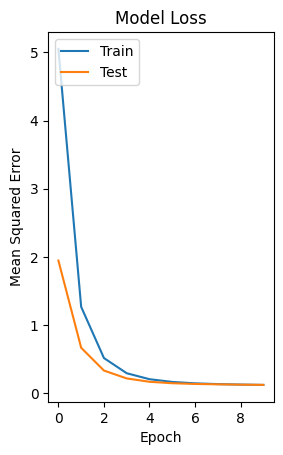

In [46]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# **Pengujian**

In [47]:
# Mendapatkan rekomendasi untuk userId tertentu
user_id = 1
top_recommendations = get_recommendations_by_teams(purchase_history, matches, user_id=user_id, N=10)

# Output hasil
if not top_recommendations.empty:
    print(f"\nRekomendasi Pertandingan untuk userId {user_id}:")
    print(top_recommendations[['ID Match', 'Home', 'Away', 'Tanggal ', 'similarity_score']].to_string(index=False))
else:
    print(f"Tidak ada rekomendasi yang relevan untuk userId {user_id}.")


Tanggal hari ini: 25-11-2024

Rekomendasi Pertandingan untuk userId 1:
 ID Match           Home          Away   Tanggal   similarity_score
      108         PERSIS Barito Putera 03-12-2024               1.0
      111  Semen Padang        Persija 07-12-2024               1.0
      124    Dewa United Barito Putera 12-12-2024               1.0
      129    Bali United       Persija 15-12-2024               1.0
      143  PSM Makassar  Barito Putera 22-12-2024               1.0
      149  Malut United        Persija 28-12-2024               1.0
      155 Barito putera        Persija 10-01-2025               1.0
      166  Madura United Barito Putera 18-01-2025               1.0
      178         PERSIS       Persija 26-01-2025               1.0
      181        Persik  Barito Putera 31-01-2025               1.0
